<a href="https://colab.research.google.com/github/alostmathematician/ISTA-366/blob/main/NB6_ISTA_322_S23_Simple_ETL_blank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wrapping up ETL with the L

The goal of this week's lesson is to teach you the process of uploading data to a database (You already followed a lesson to create a Postgres database on AWS). Now it's time to load data to it.

Before we do that though, we're going to extract data and transform it into a more useful analytical format. Thus, we'll be doing a full ETL pipeline today!

The data that we'll be extracting contains daily numbers of Covid-19 positive cases and deaths by each county and state in the US. Most dashboards or reporting metrics are going to want values 'rolled up' into a higher level. We're going to do this in two ways:

* We're going to want aggregate numbers by state. Hearing about high rates in some specific county might matter for some people, but most sources will want state-level numbers.

* We're also going to want to rollup our data into weekly aggregates vs. daily numbers. Daily numbers are problematic as some sources only report on specific days of the week. For example, hospitals might not update their stats on the weekends. Similarly U Arizona doesn't test on the weekends. This means that daily numbers aren't an accurate reflection of the overall trend, while weekly numbers are.

The last thing we'll do is some wrangling to make a unique primary key for each row.

Once that is done *then* we can upload the table to our database.

## Extracting our data

The data has been stored on my Google Drive.

We can bring the data in via our usual `pd.read_csv()`. Then we'll do a quick exploration to figure out what we need to do as far as transforms.

In [1]:
# Get pandas
import pandas as pd

In [2]:
# We'll call our data 'covid'
covid = pd.read_csv('https://docs.google.com/spreadsheets/d/1KhRW9lU_mm9svjy2T2u2Sx6UwTGcOfXx1jb1xJoxLpQ/gviz/tq?tqx=out:csv')

### Quick explore

Let's look at the head, a describe, and shape.

In [3]:
# head
covid.tail()

,date,state,county_code,county,daily_cases,daily_deaths
625620,10/15/2020,Wyoming,56037,Sweetwater,4,0
625621,10/15/2020,Wyoming,56039,Teton,1,0
625622,10/15/2020,Wyoming,56041,Uinta,3,0
625623,10/15/2020,Wyoming,56043,Washakie,0,0
625624,10/15/2020,Wyoming,56045,Weston,5,0


In [4]:
# describe
covid.describe()

,county_code,daily_cases,daily_deaths
count,625625.000000,625625.000000,625625.000000
mean,31175.358971,12.333928,0.307016
std,16267.627306,67.809433,2.486959
min,1001.000000,-2321.000000,-512.000000
25%,18169.000000,0.000000,0.000000
50%,29195.000000,1.000000,0.000000
75%,46091.000000,6.000000,0.000000
max,78030.000000,14129.000000,455.000000


In [5]:
# dtypes
covid.dtypes

date            object
state           object
county_code      int64
county          object
daily_cases      int64
daily_deaths     int64
dtype: object

In [6]:
# shape
covid.shape

(625625, 6)

OK, we can see a few things. We have six columns. Our shape tells us that we have over 600,000 rows. Our dtypes call indicates that our `date` column isn't currently a datetime. So if we're going to want to roll up by week then we'll need to convert that.

## Transforming our data

Time to get our transform going. We're going to do the following steps:

* Make `date` a datetime
* Aggregate our data by week and state and count up the number of cases/deaths
* Make a unique key that's needed for our database

### Make our datetime

You know how this is done. Just convert `date` in place.

In [7]:
# Convert date to datetime
covid['date'] = pd.to_datetime(covid['date'])

In [8]:
# Can we call a method on it to make sure it returns a datetime?
covid['date'].min()

Timestamp('2020-01-22 00:00:00')

### Groupby and aggregate

Time to groupby. We're going to group by two levels. The first is `state`, which is easy. The second is that we want to group by the calendar week. You could go and do something where you extract days and then have some rolling function that counts in groups of seven. But, pandas can actually group by calendar week if we use the `Grouper()` function!

To use `pd.Grouper()` you give it two arguments. The first is the key, which in this case is the `date` column. The second is the frequency that you want to group. We want to group on weeks so we can just specify `freq = 'w'`. The `W` tells it to group by calendar week. You can even specify what day you want the week to start on by adding a dash and a day abbreviation. So `W-MON` will tell it to group by weeks where weeks start on Monday.

For our `.agg()` we just want to sum up `daily_cases` and `daily_death` which will give us the weekly cases and deaths.

OK, let's do it and call the resulting object `covid_grouped`.

In [10]:
# Test out using grouper. Play around with different freq abbreviations and observe the result
covid_grouped_test = covid.groupby([covid['state'], pd.Grouper(key = 'date', freq='W')]).agg({'daily_cases': ['sum'], 'daily_deaths': ['sum']})
covid_grouped_test.head(10)

daily_cases daily_deaths
                           sum          sum
state   date                               
Alabama 2020-03-15          13            0
        2020-03-22         121            0
        2020-03-29         631            5
        2020-04-05         995           40
        2020-04-12        1740           48
        2020-04-19        1320           67
        2020-04-26        1518           59
        2020-05-03        1467           71
        2020-05-10        2001          103
        2020-05-17        1882           95

In [11]:
# Make covid_grouped for real
covid_grouped = covid.groupby([covid['state'], pd.Grouper(key = 'date', freq = 'W-MON')]).agg({'daily_cases' : ['sum'], 'daily_deaths': ['sum']})

In [12]:
# Check the head of covid_grouped
covid_grouped.head()

daily_cases daily_deaths
                           sum          sum
state   date                               
Alabama 2020-03-16          19            0
        2020-03-23         151            0
        2020-03-30         707           11
        2020-04-06        1048           42
        2020-04-13        1797           51

Right now see how the state and date columns are in bold. That means they got assigned as indexes and not columns. Let's reset the index to bring them back as columns. We want them as columns for date manipulation and key generation later.

In [13]:
# Reset index and check head
covid_grouped = covid_grouped.reset_index()
covid_grouped.head()

,state,date,daily_cases,daily_deaths
,,,sum,sum
0,Alabama,2020-03-16,19,0
1,Alabama,2020-03-23,151,0
2,Alabama,2020-03-30,707,11
3,Alabama,2020-04-06,1048,42
4,Alabama,2020-04-13,1797,51


Let's also rename our columns. We'll leave the first two as 'state' and 'date', but change the last two to 'weekly_cases' and 'weekly_deaths'

In [14]:
# rename to 'state', 'date', 'weekly_cases', 'weekly_deaths'
covid_grouped.columns = ['state', 'date', 'weekly_cases', 'weekly_deaths']
covid_grouped.head()

,state,date,weekly_cases,weekly_deaths
0,Alabama,2020-03-16,19,0
1,Alabama,2020-03-23,151,0
2,Alabama,2020-03-30,707,11
3,Alabama,2020-04-06,1048,42
4,Alabama,2020-04-13,1797,51


### A quick validation of our data

Let's take a minute and make sure our data makes sense. We'll extract out data from just Arizona and then do a quick barplot of the number of weekly cases in AZ.

In [15]:
# Extract just AZ observations
az_data = covid_grouped[covid_grouped['state'] == 'Arizona']

In [24]:
#For local machine you may need to install seaborn
!pip install seaborn

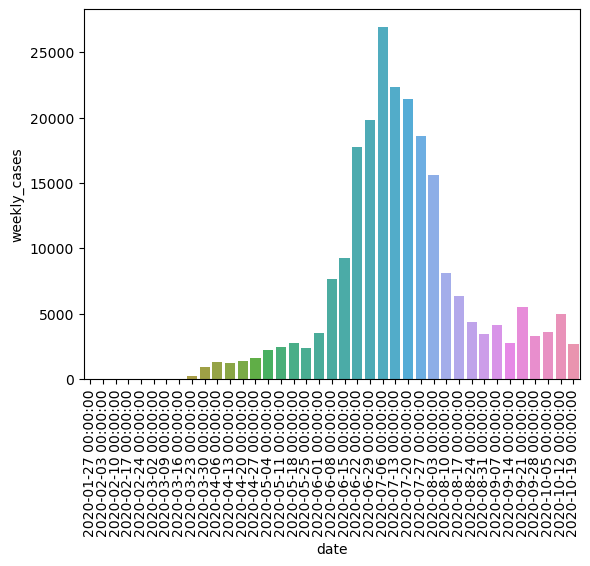

In [17]:
# Make barplot using seaborn
# The x-axis is a mess but data look right based on what we know about Covid in AZ
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.barplot(x = 'date', y = 'weekly_cases', data = az_data)
g.set_xticklabels(labels = az_data['date'],rotation=90)
plt.show()

## Transforms - Making a key

OK, our `covid_grouped` dataframe is now rolled up into a format that we want. But since we're going to push to a database we need to also make a key. A **primary key** is a unique identifying value for a row of the table. Such a key must not be duplicated in any of the rows (it wouldn't be unique if it was!).

So, we need to make a key. What should we use? There isn't a firm rule here, but ideally you want something that is easy to generate. We could imagine making a table of a bunch of random values and selecting from that. The only issue is that if we want to add more data, every time you do you'd need to make sure the key you're giving a row hasn't already been used. You could also imagine making the ID just from a squence, but again if you update you need to know where the sequence ends.

Instead of either of those two options we can do something simpler. Let's just take the date in YYYYMMDD format and then add on a code for the state. Any updates obviously won't duplicate dates. Adding on the state code ensures that each date is then unique as no states will have the same state code.

To make the key we'll do the following steps:
* Make a column called `week_start` that takes the date the grouped week began on and converts it back into a string.
* We'll remove the dashes from the current YYYY-MM-DD format
* Make numeric values for each state in the dataset
* Add those state numeric values back to the date string

### Making our date string

First we'll use our basic wrangling skills to take our date column and convert it back to a string with `.astype(str)`. We'll call the new column 'week_start'.

In [26]:
# Convert to string and check
covid_grouped['week_start'] = covid_grouped['date'].astype(str)
covid_grouped.dtypes # can see that week_start is an object

state                    object
date             datetime64[ns]
weekly_cases              int64
weekly_deaths             int64
week_start               object
dtype: object

Removing symbols from strings is really common. Luckily it's also quite easy here and we don't need regular expression. `.replace()` allows you to just specify what symbol you want it to remove first, in this case the "-", and then what you want to replace it with, in this case nothing.

Let's do this operation on 'week_start'.

In [27]:
covid_grouped.head()

,state,date,weekly_cases,weekly_deaths,week_start
0,Alabama,2020-03-16,19,0,2020-03-16
1,Alabama,2020-03-23,151,0,2020-03-23
2,Alabama,2020-03-30,707,11,2020-03-30
3,Alabama,2020-04-06,1048,42,2020-04-06
4,Alabama,2020-04-13,1797,51,2020-04-13


In [28]:
# Remove dash from week start
covid_grouped['week_start'] = covid_grouped['week_start'].str.replace('-', '')
covid_grouped.head()

,state,date,weekly_cases,weekly_deaths,week_start
0,Alabama,2020-03-16,19,0,20200316
1,Alabama,2020-03-23,151,0,20200323
2,Alabama,2020-03-30,707,11,20200330
3,Alabama,2020-04-06,1048,42,20200406
4,Alabama,2020-04-13,1797,51,20200413


### Making our state names into numeric factors

We want to assign each unique level in the 'state' column it's own numeric ID value. Pandas has a function called `factorize()` that does just that. As an argument you feed it a column that has multiple unique characters, and it'll return a unique numeric value for each. Here's an example on some test data

```
>>> states = ['washington', 'washington', 'arizona', 'california']
>>> pd.factorize(states)
(array([0, 0, 1, 2]),
 array(['washington', 'arizona', 'california'], dtype=object))
```
You can see that `pd.factorize()` took 'states` and gave the unique values a corresponding numeric value starting with zero. Test it out below if you want.


In [29]:
# If you want to test it out
states = ['washington', 'washington', 'arizona', 'california']
pd.factorize(states)

(array([0, 0, 1, 2]),
 array(['washington', 'arizona', 'california'], dtype=object))

Let's apply factorize to create a new column called 'state_id'. Note how above `factorize()` returned two arrays. The first had the ID, the second the original level. We'll need to call just that first array with `[0]` as that's all we want in the new column.

I'm also going to convert the numeric straight to a string using `.astype(str)` again. This will save us a step when we add the `state_id` string to the `week_start` string.

In [101]:
covid_grouped['state_id'] = pd.factorize(covid_grouped['state'])[0].astype(str)
covid_grouped # check it

,state,date,weekly_cases,weekly_deaths,state_id
0,Alabama,2020-03-16,19,0,0
1,Alabama,2020-03-23,151,0,0
2,Alabama,2020-03-30,707,11,0
3,Alabama,2020-04-06,1048,42,0
4,Alabama,2020-04-13,1797,51,0
...,...,...,...,...,...
1765,Wyoming,2020-09-21,552,3,53
1766,Wyoming,2020-09-28,810,1,53
1767,Wyoming,2020-10-05,875,3,53
1768,Wyoming,2020-10-12,1173,1,53


In [102]:
covid_grouped[covid_grouped['state'] == 'Delaware']

,state,date,weekly_cases,weekly_deaths,state_id
240,Delaware,2020-03-16,7,0,7
241,Delaware,2020-03-23,75,0,7
242,Delaware,2020-03-30,177,7,7
243,Delaware,2020-04-06,519,8,7
244,Delaware,2020-04-13,975,26,7
245,Delaware,2020-04-20,956,31,7
246,Delaware,2020-04-27,1437,53,7
247,Delaware,2020-05-04,1113,57,7
248,Delaware,2020-05-11,1261,43,7
249,Delaware,2020-05-18,1293,71,7


Great. We can see we have our 'state_id' column now. Let's join that to the front of 'week_start' so this way our key format is IDYYYYMMDD where ID at the start of the string is the state ID.

If you want to merge two strings in different columns you can literally just add them together. So let's add the 'state_id' column to the 'week_start' column. Let's create a new column called 'wk_st_id' for "week state id."

In [31]:
# Add strings
covid_grouped['wk_st_id'] = covid_grouped['state_id'] + covid_grouped['week_start']
covid_grouped #check

,state,date,weekly_cases,weekly_deaths,week_start,state_id,wk_st_id
0,Alabama,2020-03-16,19,0,20200316,0,020200316
1,Alabama,2020-03-23,151,0,20200323,0,020200323
2,Alabama,2020-03-30,707,11,20200330,0,020200330
3,Alabama,2020-04-06,1048,42,20200406,0,020200406
4,Alabama,2020-04-13,1797,51,20200413,0,020200413
...,...,...,...,...,...,...,...
1765,Wyoming,2020-09-21,552,3,20200921,53,5320200921
1766,Wyoming,2020-09-28,810,1,20200928,53,5320200928
1767,Wyoming,2020-10-05,875,3,20201005,53,5320201005
1768,Wyoming,2020-10-12,1173,1,20201012,53,5320201012


## Making our table of state keys

Now that we have our encoded key for our covid_grouped table we need to do two final things. First, let's make a second table that contains the relationship between the state_id and the state. This way people can make sql queries on the covid data using the state name if they wanted.

After that we'll drop the unnecessary columns from `covid_grouped`.

Making our 'states' table is easy. Just select the two columns of 'state_id' and 'state' and use `drop_duplicates() to get just unique values. This way we'll have each state only once. Call the resulting dataframe 'states'

In [32]:
# Make states by selecting columns and dropping duplicates
states = covid_grouped[['state_id', 'state']].drop_duplicates()
states.head() # check

,state_id,state
0,0,Alabama
32,1,Alaska
64,2,Arizona
103,3,Arkansas
135,4,California


Now we'll drop 'week_start' and 'state' from `covid_grouped` as those columns are redundant. The week start is just the 'date' column which we'll keep. And we have a 'state_id' column so we don't need the state name.

`.drop()` is useful here.

In [33]:
# Drop columns
covid_grouped = covid_grouped.drop(columns=['week_start', 'state'])
covid_grouped.head()

,date,weekly_cases,weekly_deaths,state_id,wk_st_id
0,2020-03-16,19,0,0,020200316
1,2020-03-23,151,0,0,020200323
2,2020-03-30,707,11,0,020200330
3,2020-04-06,1048,42,0,020200406
4,2020-04-13,1797,51,0,020200413


## Pushing to our/your SQL database

Alright, let's go and push our two tables to the database that we set up earlier in the week.

Pushing data to a database has two steps.

1. We define our table columns and the datatypes within in
2. We upload data into the columns that we created
3. We commit the changes

Steps 1 and 2 are done using SQL syntax in a similar structure as we used to make queries. We'll write our commands and then execute them using a cursor just like before. Then we'll commit our changes and close our cursor.

### Import SQL functions

First, go and run the functions we've been using. **Update** the `get_conn_cur()` function so that it connects to your database!

In [34]:
#If you are using AWS, use this cell
import psycopg2
aws_host = "test-hw-db.ctxkekv3vnim.us-east-2.rds.amazonaws.com"
def get_conn_cur():
 # UPDATE WITH YOUR INFO!

 conn = psycopg2.connect(
    host=aws_host,
    database="hw3_db",
    user="postgres",
    password="123456789",
    port='5432'
    )

 cur = conn.cursor()
 return(conn, cur)

In [ ]:
#If you using local MySQL use this cell. (Note: if you are using local MySQL you must run this notebook on your local Jupyter, it won't work on Google Colab)
import mysql.connector
def get_conn_cur():
    cnx = mysql.connector.connect(user='root', password='',
          host='127.0.0.1',
          database='YOUR DB NAME HERE');
    return (cnx, cnx.cursor())

In [35]:
# Run or old functions in case we want to check our data!

# run_query function
def run_query(query_string):

 conn, cur = get_conn_cur() # get connection and cursor

 cur.execute(query_string) # executing string as before

 my_data = cur.fetchall() # fetch query data as before

 # here we're extracting the 0th element for each item in cur.description
 colnames = [desc[0] for desc in cur.description]

 cur.close() # close
 conn.close() # close

 return(colnames, my_data) # return column names AND data

# Column name function for checking out what's in a table
def get_column_names(table_name): # arguement of table_name
 conn, cur = get_conn_cur() # get connection and cursor

 # Now select column names while inserting the table name into the WERE
 column_name_query = """SELECT column_name FROM information_schema.columns
    WHERE table_name = '%s' """ %table_name

 cur.execute(column_name_query) # exectue
 my_data = cur.fetchall() # store

 cur.close() # close
 conn.close() # close

 return(my_data) # return

# Check table_names
def get_table_names():
  conn, cur = get_conn_cur() # get connection and cursor

  # query to get table names
  table_name_query = """SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public' """

  cur.execute(table_name_query) # execute
  my_data = cur.fetchall() # fetch results

  cur.close() #close cursor
  conn.close() # close connection

  return(my_data) # return your fetched results

# make sql_head function
def sql_head(table_name):
 conn, cur = get_conn_cur() # get connection and cursor

 # Now select column names while inserting the table name into the WERE
 head_query = """SELECT * FROM %s LIMIT 5; """ %table_name

 cur.execute(head_query) # exectue
 colnames = [desc[0] for desc in cur.description] # get column names
 my_data = cur.fetchall() # store first five rows

 cur.close() # close
 conn.close() # close

 df = pd.DataFrame(data = my_data, columns = colnames) # make into df

 return(df) # return

# drop a table from your rdb (if you try to create a table that already exists, it'll throw an error)
def my_drop_table(tab_name):
  conn, cur = get_conn_cur()
  tq = """DROP TABLE IF EXISTS %s CASCADE;""" %tab_name
  cur.execute(tq)
  conn.commit()

## Create weekly table in database

Let's go and make a table called 'weekly' that we'll insert our main 'covid_grouped' dataset into'

The main call to make a table is `CREATE TABLE new_table_name ()`. Inside the parentheses you then give it your column name, your datatype, and if you can have null values in there. We want to make five columns. The first one we want to be our 'wk_st_id' which we'll set as an integer and a primary key.

I've written the query for you.

**NOTE** - `VARCHAR(255)` is the way to specify a character column. Inside the parentheses is the max length allowed. 'state_id' doesn't need to be a character, but I specified it as one to demonstrate some variety. It's also how we already had the datatype specified in our 'covid_grouped' dataframe. We could specify the column as an integer but then we'd have to also change 'state_id' in 'covid_grouped' to an integer so the datatypes being pushed match.

In [36]:
# drop the table if it already exists (uncomment)
# my_drop_table('weekly_stats')

# query with wk_st_id as an integer and primary key
# date as a timestamp
# cases and deaths as intergers
# state_id as characters
tq = """CREATE TABLE weekly_stats (
     wk_st_id INT PRIMARY KEY,
     date timestamp NOT NULL ,
     weekly_cases BIGINT NOT NULL,
     weekly_deaths BIGINT NOT NULL,
     state_id BIGINT NOT NULL
     );"""

Now that we have that let's get a connection and cursor object

In [37]:
# Get our connection and cursor and assign to conn and cur
conn, cur = get_conn_cur()


To create the table we can just execute the query using `cur.execute()`.

In [38]:
# execute our query we wrote above
cur.execute(tq)

And finally just commit the table. Doing so just finalizes everything you did and will make it accessable to other users.

In [39]:
# commit
conn.commit()

Let's check that our table name and column names are in there using the functions we made in previous lessons.

In [40]:
# Is the table there?
get_table_names()

[('weekly_stats',)]

In [41]:
# All of our column names?
get_column_names(table_name='weekly_stats')

[('wk_st_id',),
 ('date',),
 ('weekly_cases',),
 ('weekly_deaths',),
 ('state_id',)]

### Updating our table

I actually made a mistake above. I said the primary key should be an integer, but actually it needs to be something called a big interger. This is because regular integers can only store values between -2147483648 and +2147483647. Our current wk_st_id values get larger than that. So, we need to change the datatype of that column!

To do this, or change any datatype for that matter, we write another query. In this case, the main arguments are ALTER TABLE and ALTER COLUMN. The first just points to the table in the database, the second the column in that database. Then you just tell it what datatype you want to use. the general format is as follows:

```
ALTER TABLE table_name
 ALTER COLUMN column_to_update TYPE datatype_to_use
```

I've written the query below. We'll create a cursor and commit everything in one go just like above.

In [42]:
conn, cur = get_conn_cur()
cur = conn.cursor()
uq = """ALTER TABLE weekly_stats
     ALTER COLUMN wk_st_id TYPE BIGINT;"""
cur.execute(uq)
conn.commit()

We can run a quick query to get the datatypes. Remember how we called the 'information_schema' before to get column names? We can also get the data types by selecting that information.

In [43]:
conn, cur = get_conn_cur()
cur = conn.cursor()
uq = """SELECT column_name, data_type
     FROM information_schema.columns
     WHERE table_name = 'weekly_stats';"""
cur.execute(uq)
print(cur.fetchall())
conn.close()

[('wk_st_id', 'bigint'), ('date', 'timestamp without time zone'), ('weekly_cases', 'bigint'), ('weekly_deaths', 'bigint'), ('state_id', 'bigint')]


Great, we can see all of our column names and corresponding datatypes. We can see that 'wk_st_id' is now a 'bigint.' This brings up an important point when designing a database. You need to be sure to make your columns are big enough to store approved values now, but also in the future.

## Make states table

Can you go and make a second table called 'states'? We're going to want to take that 'states' dataframe and add it to our database. This one should have only two columns, both with character datatypes like above. The primary key should be 'state_id'

In [ ]:
states.head()

In [44]:
# Make your states table
conn, cur = get_conn_cur()
cur = conn.cursor()
tq = """CREATE TABLE states (
     state_id BIGINT PRIMARY KEY,
     state VARCHAR(255) NOT NULL
     );"""
cur.execute(tq)
conn.commit()
conn.close()

In [45]:
# check that the table is tere
get_table_names()

[('weekly_stats',), ('states',)]

In [46]:
# Check that the column names are there
get_column_names(table_name='states')
sql_head('states')

,state_id,state


In [47]:
# Might as well check the datatypes
conn, cur = get_conn_cur()
cur = conn.cursor()
uq = """SELECT column_name, data_type
     FROM information_schema.columns
     WHERE table_name = 'states';"""
cur.execute(uq)
print(cur.fetchall())
conn.close()

[('state_id', 'bigint'), ('state', 'character varying')]


## Putting information in the database

Now we have a couple empty tables sitting in our database waiting for data. As you can imagine, the general process is an extension of what we did above. We write a query that specifies the table and columns we want to insert data into, and then what data we want to put in there.

The main argument to do this is INSERT into followed by VALUES. The generalized string format is:

```
"INSERT INTO table_name(column_names) VALUES (values_for_each_column)"
```

This process is typically done row-wise meaning you insert one row at a time. For example, this string would add just a single row of data into our 'weekly_stats' table:

```
"INSERT INTO weekly_stats(wk_st_id,date,weekly_cases,weekly_deaths,state_id
 VALUES(0020200316, 2020-03-16 00:00:00, 19, 0, 00)"
```

**OK, but does this mean we have to write and execute a query for each and every row in our dataframe?** No, of course not. While you could update it a single row at a time using `cur.execute()` and loop through every row of your dataset, that would be super slow as you'd be generating a cursor, executing, and closing each and every time.

Instead you can use `cur.executemany()`. This allows you to, well, execute many actions at once. It is a bit more involved in the string you'll have to write as you'll have to use string formatting (`%s`) to generate the string for each row. But, this is simpler and MUCH MUCH faster than using a loop with single operations.

There are some other bits to make this work, but we'll cover them as we go. Let's get started!

First, we need to reorder our columns in the dataframe to match the column order of the database.

In [48]:
# What's the order of our weekly_stats column?
get_column_names(table_name='weekly_stats')

[('wk_st_id',),
 ('date',),
 ('weekly_cases',),
 ('weekly_deaths',),
 ('state_id',)]

In [49]:
# Reorder covid_grouped to match
covid_grouped = covid_grouped[['wk_st_id', 'date', 'weekly_cases', 'weekly_deaths', 'state_id']]
covid_grouped.head()

,wk_st_id,date,weekly_cases,weekly_deaths,state_id
0,020200316,2020-03-16,19,0,0
1,020200323,2020-03-23,151,0,0
2,020200330,2020-03-30,707,11,0
3,020200406,2020-04-06,1048,42,0
4,020200413,2020-04-13,1797,51,0


OK, first think to point out. SQL wants to receive the data as a tuple. Each row of ours is currently a row in a dataframe. So we need to convert each row to a tuple. We can use numpy to do this. Below I write a list comprehension to do this. List comprehensions are essentially simplified for loops.

The first part is the action. It's saying 'make a tuple with x'. The second part is just saying the variable name in the sequence. The third part is the list of data. In this case we're making a list of data by converting our dataframe to a numpy array. Play around making a cell and running `covid_grouped.to_numpy()` if you want to see more specifically what this is doing. I'm going to just run the list comprehension for now.

In [50]:
import numpy as np

covid_np = covid_grouped.to_numpy();
#Mysql does not understand the timestamp from python so we can convert the timestamp to string.
covid_np[:,1] = np.vectorize(lambda x: str(x))(covid_np[:,1])
data_tups = [tuple(x) for x in covid_np]


What's in `data_tups`? Let's look at the 3rd position.

In [51]:
# Check out an example
data_tups[2]

('020200330', '2020-03-30 00:00:00', 707, 11, '0')

Great, so now that's in a format that's ready for VALUES part of our INSERT string. Now we can write our insert string that will take those values.

Remember from before that %s allows you to insert a value into a string. So if we did something like `'I need %s points to pass' % points_needed` it would insert whatever 'points_needed' is defined as into that string.

In [52]:
# and example
points_needed = 20
'I need %s points to pass' % points_needed

'I need 20 points to pass'

What we need to do for our query is insert one of our tuples from 'data_tups' into VALUES. WE have five values in each tuple, so we need to just write '%s inside that string five times. Let's write our insert string.

In [53]:
iq = """INSERT INTO weekly_stats(wk_st_id,date,weekly_cases,weekly_deaths,state_id) VALUES(%s, %s, %s, %s, %s);"""
iq

'INSERT INTO weekly_stats(wk_st_id,date,weekly_cases,weekly_deaths,state_id) VALUES(%s, %s, %s, %s, %s);'

You can test if it's working by trying to add a tuple to your insert string.

In [54]:
# Does it work?
iq % data_tups[4]

'INSERT INTO weekly_stats(wk_st_id,date,weekly_cases,weekly_deaths,state_id) VALUES(020200413, 2020-04-13 00:00:00, 1797, 51, 0);'

### Finally pushing data to the database

Now we can finally use `executemany() to push our database. This'll take two arguments. The first is the query string, the section is our tuples. It'll go and make an insert string for each and every tuple and therefore insert each row. We still need to open a connection, make a cursor, close, and commit.

**NOTE** this will take a minute or so!

In [55]:
# Upload data
conn, cur = get_conn_cur()
cur.executemany(iq, data_tups)
conn.commit()
conn.close()

Let's give it a check with a simple query

In [56]:
sq = """ SELECT COUNT(DISTINCT(wk_st_id)) FROM weekly_stats
     LIMIT 5;"""
run_query(sq)

(['count'], [(1770,)])

**SUCCESS**

### Add data to states table

Wonderful! Can you now go and populate the 'states' table?

You'll need to make tuples and modify the insert statement to take only two arguments along with the proper table name and column names

In [63]:
import numpy as np
states_np = states.to_numpy()
states_np[:,0] = np.vectorize(lambda x: int(x))(states_np[:,0])
state_tup = [tuple(x) for x in states_np]
state_tup

[(0, 'Alabama'),
 (1, 'Alaska'),
 (2, 'Arizona'),
 (3, 'Arkansas'),
 (4, 'California'),
 (5, 'Colorado'),
 (6, 'Connecticut'),
 (7, 'Delaware'),
 (8, 'District of Columbia'),
 (9, 'Florida'),
 (10, 'Georgia'),
 (11, 'Hawaii'),
 (12, 'Idaho'),
 (13, 'Illinois'),
 (14, 'Indiana'),
 (15, 'Iowa'),
 (16, 'Kansas'),
 (17, 'Kentucky'),
 (18, 'Louisiana'),
 (19, 'Maine'),
 (20, 'Maryland'),
 (21, 'Massachusetts'),
 (22, 'Michigan'),
 (23, 'Minnesota'),
 (24, 'Mississippi'),
 (25, 'Missouri'),
 (26, 'Montana'),
 (27, 'Nebraska'),
 (28, 'Nevada'),
 (29, 'New Hampshire'),
 (30, 'New Jersey'),
 (31, 'New Mexico'),
 (32, 'New York'),
 (33, 'North Carolina'),
 (34, 'North Dakota'),
 (35, 'Northern Mariana Islands'),
 (36, 'Ohio'),
 (37, 'Oklahoma'),
 (38, 'Oregon'),
 (39, 'Pennsylvania'),
 (40, 'Puerto Rico'),
 (41, 'Rhode Island'),
 (42, 'South Carolina'),
 (43, 'South Dakota'),
 (44, 'Tennessee'),
 (45, 'Texas'),
 (46, 'Utah'),
 (47, 'Vermont'),
 (48, 'Virgin Islands'),
 (49, 'Virginia'),
 (50, 'W

In [58]:
get_column_names(table_name='states')

[('state_id',), ('state',)]

In [65]:
# new insert query
iq = """INSERT INTO states(state_id, state) VALUES (%s,%s);"""

In [66]:
# Upload data
conn,cur = get_conn_cur()
cur.executemany(iq,state_tup)
conn.commit()
conn.close()

## Run some test queries!

In [67]:
# Test query to look at the first five rows of states
sq = """ SELECT * FROM states
     LIMIT 5;"""
run_query(sq)

(['state_id', 'state'],
 [(0, 'Alabama'),
  (1, 'Alaska'),
  (2, 'Arizona'),
  (3, 'Arkansas'),
  (4, 'California')])

In [68]:
# And weekly_stats
sq = """ SELECT * FROM weekly_stats
     LIMIT 5;"""
run_query(sq)

(['wk_st_id', 'date', 'weekly_cases', 'weekly_deaths', 'state_id'],
 [(20200316, datetime.datetime(2020, 3, 16, 0, 0), 19, 0, 0),
  (20200323, datetime.datetime(2020, 3, 23, 0, 0), 151, 0, 0),
  (20200330, datetime.datetime(2020, 3, 30, 0, 0), 707, 11, 0),
  (20200406, datetime.datetime(2020, 4, 6, 0, 0), 1048, 42, 0),
  (20200413, datetime.datetime(2020, 4, 13, 0, 0), 1797, 51, 0)])

In [107]:
sql = """SELECT count(DISTINCT(wk_st_id)) as count FROM weekly_stats;"""
run_query(sql)

(['count'], [(1770,)])

In [104]:

# Do a subquery getting just weekly stats where the state is 'Arizona'
sq = """ SELECT * FROM weekly_stats
     WHERE state_id = (SELECT state_id FROM states WHERE state = 'Arizona')
     LIMIT 5;"""
run_query(sq)

(['wk_st_id', 'date', 'weekly_cases', 'weekly_deaths', 'state_id'],
 [(220200127, datetime.datetime(2020, 1, 27, 0, 0), 0, 0, 2),
  (220200203, datetime.datetime(2020, 2, 3, 0, 0), 0, 0, 2),
  (220200210, datetime.datetime(2020, 2, 10, 0, 0), 0, 0, 2),
  (220200217, datetime.datetime(2020, 2, 17, 0, 0), 0, 0, 2),
  (220200224, datetime.datetime(2020, 2, 24, 0, 0), 0, 0, 2)])

In [103]:
get_column_names(table_name='weekly_states')

[]